# Absorbing boundary

This script demonstrates the utility of the absorbing boundary, which is an imaginary addition to the potential, to simulate the evolution of bounded potentials (e.g., such as a soft-core Coulomb potential, a Morse potential that has a bounded arm).

In [1]:
from imag_time_propagation import ImgTimePropagation, np, fftpack
from scipy.signal import blackman
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # enable log color plot
from numba import njit # compile python

In [2]:
# Changing the default size of all the figures 
plt.rcParams['figure.figsize'] = [25, 6]

In [3]:
# Define parameters of an atom (a single-electron model of Ar) in the external laser field

# laser field frequency
omega_laser = 0.06

# the final time of propagation (= 8 periods of laser oscillations)
t_final = 8 * 2. * np.pi / omega_laser

# amplitude of the laser field strength
F = 0.04

# the amplitude of grid
x_amplitude = 100.

# the time step
dt = 0.05

@njit
def laser(t):
    """
    The strength of the laser field.
    Always add an envelop to the laser field to avoid all sorts of artifacts.
    We use a sin**2 envelope, which resembles the Blackman filter
    """
    return F * np.sin(omega_laser * t) * np.sin(np.pi * t / t_final) ** 2

@njit
def v(x, t=0.):
    """
    Potential energy.
    
    Define the  potential energy as a sum of the soft core Columb potential
    and the laser field interaction in the dipole approximation.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) + x * laser(t)

@njit
def diff_v(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5) + laser(t)

@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
                                                
@njit
def diff_k(p, t=0.):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p

sys_params = dict(
    dt=dt,
    x_grid_dim=1024,
    x_amplitude=x_amplitude,
    
    k=k,
    diff_k=diff_k,
    v=v,
    diff_v=diff_v,
)

In [4]:

#########################################################################
#
#   Define functions for testing and visualizing
#
#########################################################################


def test_propagation(sys):
    """
    Run tests for the specified propagators and plot the probability density
    of the time dependent propagation
    :param sys: class that propagates
    """
    # Set the ground state wavefunction as the initial condition
    sys.get_stationary_states(1)
    sys.set_wavefunction(sys.stationary_states[0])

    iterations = 748
    steps = int(round(t_final / sys.dt / iterations))

    # display the propagator
    plt.imshow(
        [np.abs(sys.propagate(steps)) ** 2 for _ in range(iterations)],
        origin='lower',
        norm=LogNorm(vmin=1e-12, vmax=0.1),
        aspect=0.4, # image aspect ratio
        extent=[sys.x.min(), sys.x.max(), 0., sys.t]
    )
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')
    plt.colorbar()


def test_Ehrenfest1(sys):
    """
    Test the first Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.x_average))

    dx_dt = np.gradient(sys.x_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dx_dt - sys.x_average_rhs)))

    plt.plot(times, dx_dt, '-r', label='$d\\langle\\hat{x}\\rangle / dt$')
    plt.plot(times, sys.x_average_rhs, '--b', label='$\\langle\\hat{p}\\rangle$')
    plt.legend()
    plt.ylabel('momentum')
    plt.xlabel('time $t$ (a.u.)')


def test_Ehrenfest2(sys):
    """
    Test the second Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.p_average))

    dp_dt = np.gradient(sys.p_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dp_dt - sys.p_average_rhs)))

    plt.plot(times, dp_dt, '-r', label='$d\\langle\\hat{p}\\rangle / dt$')
    plt.plot(times, sys.p_average_rhs, '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
    plt.legend()
    plt.ylabel('force')
    plt.xlabel('time $t$ (a.u.)')

In [5]:
#########################################################################
#
#   Declare the propagators
#
#########################################################################

sys_no_abs_boundary = ImgTimePropagation(**sys_params)

@njit
def abs_boundary(x):
    """
    Absorbing boundary similar to the Blackman filter
    """
    return np.sin(0.5 * np.pi * (x + x_amplitude) / x_amplitude) ** (0.05 * dt)

sys_with_abs_boundary = ImgTimePropagation(
    abs_boundary=abs_boundary,
    **sys_params
)


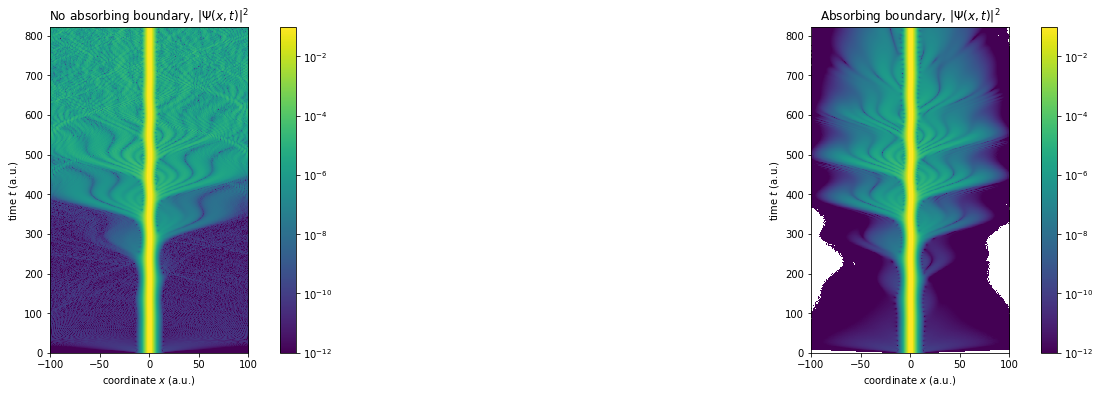

In [6]:
#########################################################################
#
# Test propagation in the context of High Harmonic Generation
#
#########################################################################

plt.subplot(121)
plt.title("No absorbing boundary, $|\\Psi(x, t)|^2$")
test_propagation(sys_no_abs_boundary)

plt.subplot(122)
plt.title("Absorbing boundary, $|\\Psi(x, t)|^2$")
test_propagation(sys_with_abs_boundary)

plt.show()


No absorbing boundary error in the first Ehrenfest relation: 
2.81e-02

No absorbing boundary error in the second Ehrenfest relation: 
2.97e-04

With absorbing boundary error in the first Ehrenfest relation: 
5.85e-03

With absorbing boundary error in the second Ehrenfest relation: 
1.59e-04


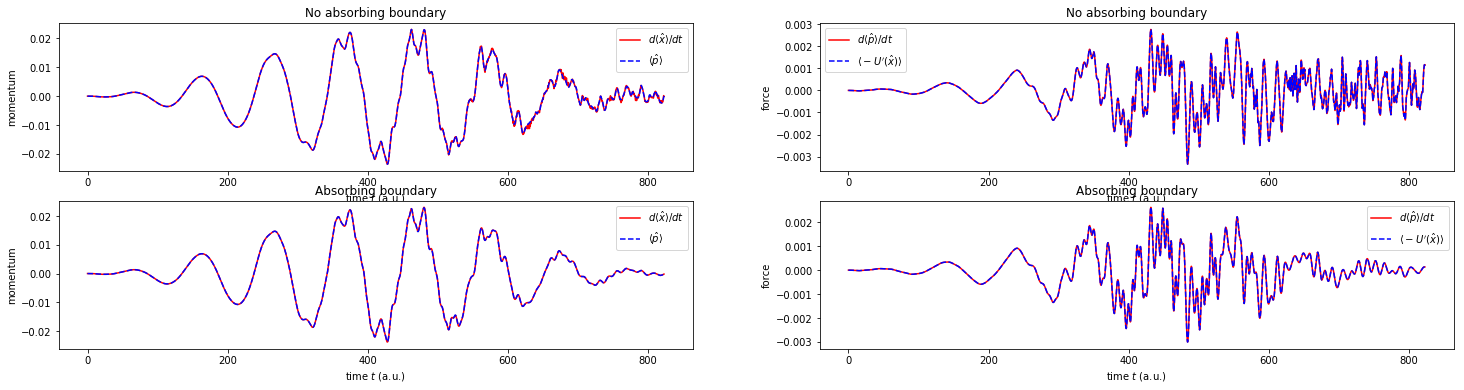

In [7]:
plt.subplot(221)
plt.title("No absorbing boundary")
print("\nNo absorbing boundary error in the first Ehrenfest relation: ")
test_Ehrenfest1(sys_no_abs_boundary)

plt.subplot(222)
plt.title("No absorbing boundary")
print("\nNo absorbing boundary error in the second Ehrenfest relation: ")
test_Ehrenfest2(sys_no_abs_boundary)

plt.subplot(223)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the first Ehrenfest relation: ")
test_Ehrenfest1(sys_with_abs_boundary)

plt.subplot(224)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the second Ehrenfest relation: ")
test_Ehrenfest2(sys_with_abs_boundary)

plt.show()

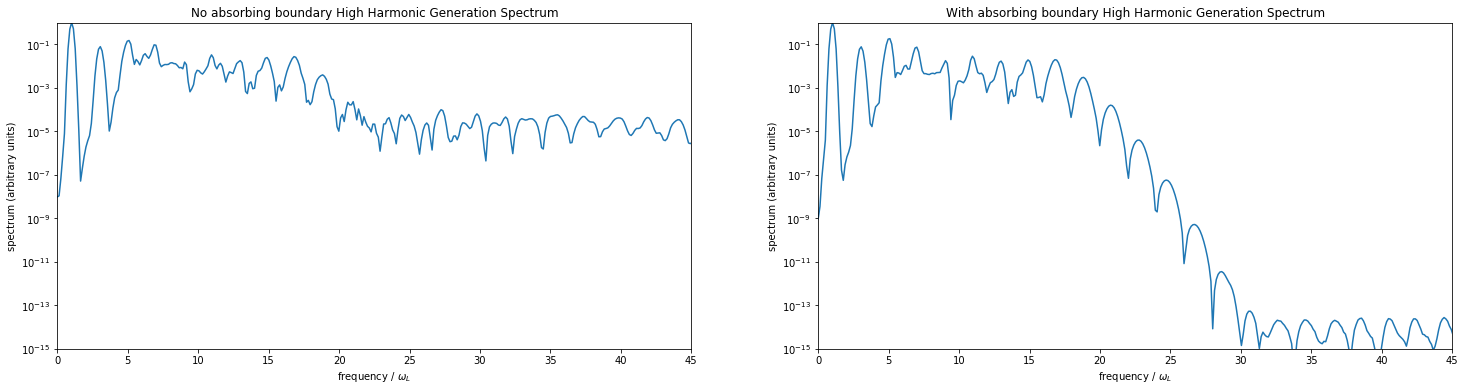

In [8]:
def plot_spectrum(sys):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(sys.p_average_rhs)
    k = np.arange(N)

    # frequency range
    omegas = (k - N / 2) * np.pi / (0.5 * sys.t)

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** k * blackman(N) * sys.p_average_rhs)
    ) ** 2
    spectrum /= spectrum.max()

    plt.semilogy(omegas / omega_laser, spectrum)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel('frequency / $\\omega_L$')
    plt.xlim([0, 45.])
    plt.ylim([1e-15, 1.])

plt.subplot(121)
plt.title("No absorbing boundary High Harmonic Generation Spectrum")
plot_spectrum(sys_no_abs_boundary)

plt.subplot(122)
plt.title("With absorbing boundary High Harmonic Generation Spectrum")
plot_spectrum(sys_with_abs_boundary)

plt.show()